# Phase 1: Convolutional Neural Networks

**In this notebook we will explore the beginnings of building a sturdy, accurate (and precise) neural network with the Cifar-10 dataset.**


The goal of this notebook is to address the optimum parameters in which the model can most accurately identify the objects and beings in images. 

For more information, please go to https://www.cs.toronto.edu/~kriz/cifar.html 

---

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from keras.layers import Conv2D, Flatten
import time
starting_time = time.time()

## Read Data

**As the data format is in a pickled file, we will need to un-pickle all of the batches (1 - 5, and the test batch)**

In [2]:
#define the unpickle function provided by the readme.html file with the data

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Pre Processing

### Creating a Function, Unpickling and Preparing The Data

I decided to create a function to prepare the data, as well as another function (due to computing limitations) to resize and rescale the images. 

- firstly appending all of the batches into one training set, with labels and data in two sets.
- I also took the opportunity to rotate the images 90º as they were originally the wrong way up. This would not be a problem for the algorithm, as it would process images sideways, however, as the end user is a human, they would typically be taken in the land-down format.
-  Another important factor of the data would be normalisation of the data, converting them into numbers between 0 and 1.

In [3]:
def preparecifar10(batches):
    _data = []
    _labels = []
    
    # Load and concatenate all batches
    for batch in batches:
        data = batch[b'data']
        labels = batch[b'labels']

        #put data in array format
        data = np.array(data, dtype=np.float32)
        labels = np.array(labels, dtype=np.int32)

        #reshape the data to combine RGB elements in one image
        images = data.reshape(-1, 3, 32, 32)
        images = np.swapaxes(images, 1, 3)

        #normalise the data to fit between 0 and 1, then rotate, then resize and rescale
        images = images / 255.0
        images = tf.image.rot90(images,3)
        _data.append(images)
        _labels.append(labels)
    
    # Convert lists to numpy arrays
    _data = np.concatenate(_data, axis=0)
    _labels = np.concatenate(_labels, axis=0)

    return _data, _labels


In [4]:
#unpickle train data
batches = [unpickle(f'data/cifar-10-batches-py/data_batch_{i}') for i in range(1, 6)]

#unpickle test data
tests = [unpickle(f'data/cifar-10-batches-py/test_batch')]

### Apply the functions to prepare the data. 

In [5]:
train_images, train_labels = preparecifar10(batches)
test_images, test_labels = preparecifar10(tests)

## Metadata Unpickle

**The metadata contains label names of each image (essentially the class that we are trying to identify when presented with new data). This means that it will be important to map the name of the label to the corresponding numeric format.** 



*"The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:
label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc."*
(https://www.cs.toronto.edu/~kriz/cifar.html )


In [6]:
#load the metadata
metadata = unpickle('data/cifar-10-batches-py/batches.meta')

In [7]:
#there are 10 classes in the dataset
len(metadata[b'label_names'])

10

In [8]:
#the unique labels are from 0 - 9 in our training set - as specified at https://www.cs.toronto.edu/~kriz/cifar.html 
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [9]:
#loop over the label names and isolate only the text, as the data was in byte format, as follows: b'labelname'
clean = []
for i in metadata[b'label_names']:
    clean.append(str(i).split("'")[1])

In [10]:
#the resulting list
clean

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
#Create a dictionary with each label and corresponding number
labeldict = []
for i in range(len(np.unique(train_labels))):
    labeldict.append({np.unique(train_labels)[i]:metadata[b'label_names'][i]})
    

In [12]:
classnames = dict(zip(np.unique(train_labels),clean))

**Now the names of the classes will correspond - this will not matter for the computer, but it is helpful for us to verify**

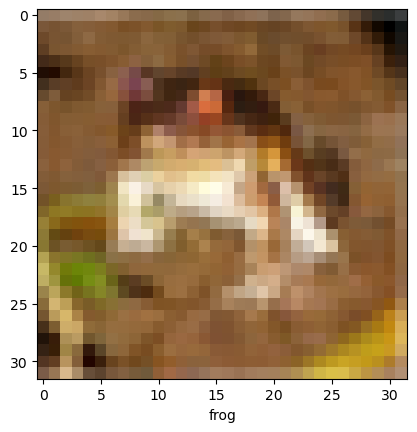

In [13]:
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.xlabel(classnames[train_labels[0]]);

The label corresponds to the picture of a frog, so that we can output a qualitative title for the user

## Exploratory analysis

**https://www.cs.toronto.edu/~kriz/cifar.html states that the classes should all contain 5000 instances, but we will check**


/var/folders/sm/8s2c1j894rq6v788yfhxt27r0000gn/T/ipykernel_5496/3745272211.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


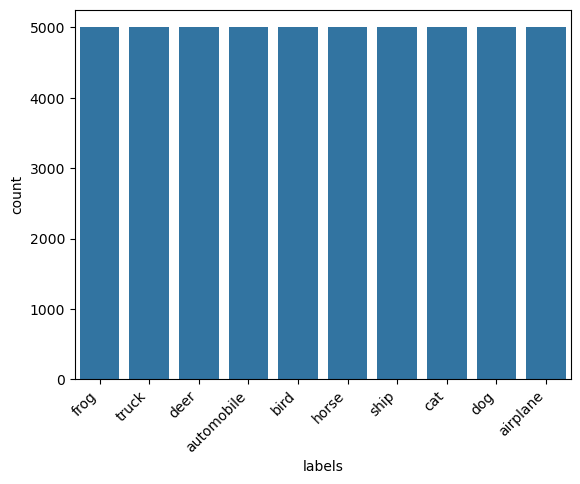

In [14]:
ax = sns.countplot(x=pd.Series(train_labels).map(classnames))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel('labels');

**This dataset seems perfectly balanced, the unpickling has been successful**

## Fit the model

### We will now fit some models and run some tests on the most efficient number of epochs for this first phase. 

We will be working with untreated data (i.e. no augmentation) and the models will take the following shape:

---
- #### Model 1 - A simple model with no convolutional layers.
      This will test a basic model, as well as being able to measure the "purest" performance.
---

- #### Model 2 - Adding 3 convolutional layers with 32 neurons in each layer.
      This will measure the efficiency of the convolutional layers compared to the simple model.

--- 
- #### Model 3 - Tweaking model 2, slowly incrementing the number of neurons in each convolutional layer.
      This will broaden the neural network to see if the number of neurons have a positive or negative effect on the outcome.
---

- #### Model 4 - Adding Pooling layers between the convolutions.
      This introduce an average pool to see if the neural network improves when reducing clutter for the model to process and only find the most important features in the image

### Train / Validation Split

**Firstly we will split training data into training and validation sets, setting random state to ensure consistency in data**

In [15]:
training_images, validation_images, training_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

 ---

## Model 1 - Simple untreated model

In [16]:

##Set one hidden layer with 128 neurons
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Flatten(input_shape=(32,32,3)))
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dense(10, activation='softmax'))


#Compile with sparse categorical crossentropy 
model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


#Run the model with validation set - batch size of 32
model1_history = model1.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=30, 
    validation_data=(validation_images, validation_labels))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2678 - loss: 2.0398 - val_accuracy: 0.3580 - val_loss: 1.7878
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3681 - loss: 1.7644 - val_accuracy: 0.3782 - val_loss: 1.7233
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3980 - loss: 1.6876 - val_accuracy: 0.4057 - val_loss: 1.6654
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4090 - loss: 1.6611 - val_accuracy: 0.4077 - val_loss: 1.6547
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4200 - loss: 1.6309 - val_accuracy: 0.4165 - val_loss: 1.6336
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4325 - loss: 1.5998 - val_accuracy: 0.4131 - val_loss: 1.6448
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4351 - loss: 1.5915 - val_accuracy: 0.4219 - val_loss: 1.6138
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4453 - loss: 1.5680 - val_accurac

**The basic model seems to perform poorly when training, but it does not seem to be having trouble with overfitting**

In [17]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   68.88994789123535  seconds


In [18]:
#testing our test set against the predictions
test_loss, test_acc = model1.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - 452us/step - accuracy: 0.4385 - loss: 1.5674

Test accuracy: 0.43849998712539673


**The model performs just as poorly on the test set**

In [19]:
probability_model1 = tf.keras.Sequential([model1, 
                                         tf.keras.layers.Softmax()])

In [20]:
predictions1 = probability_model1.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step


**The following two functions were provided in the curriculum to be able to plot the predicted images with their predicted labels and true ones**

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(clean[predicted_label],
                                100*np.max(predictions_array),
                                clean[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

**View model performance on one instance**

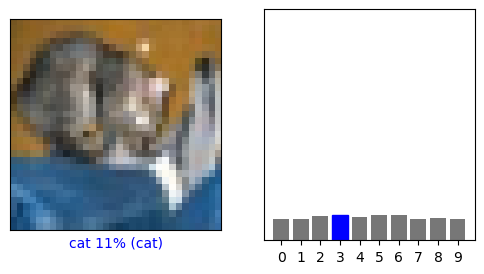

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions1[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions1[i],  test_labels)
plt.show()

**In the first instance, we see that the model was very marginally able to predict that it is a cat. This is not very promising as we can see that there is a relatively wide spread when it comes to correctly identifying the correct label. We will check some of the other labels to see if this is the case**

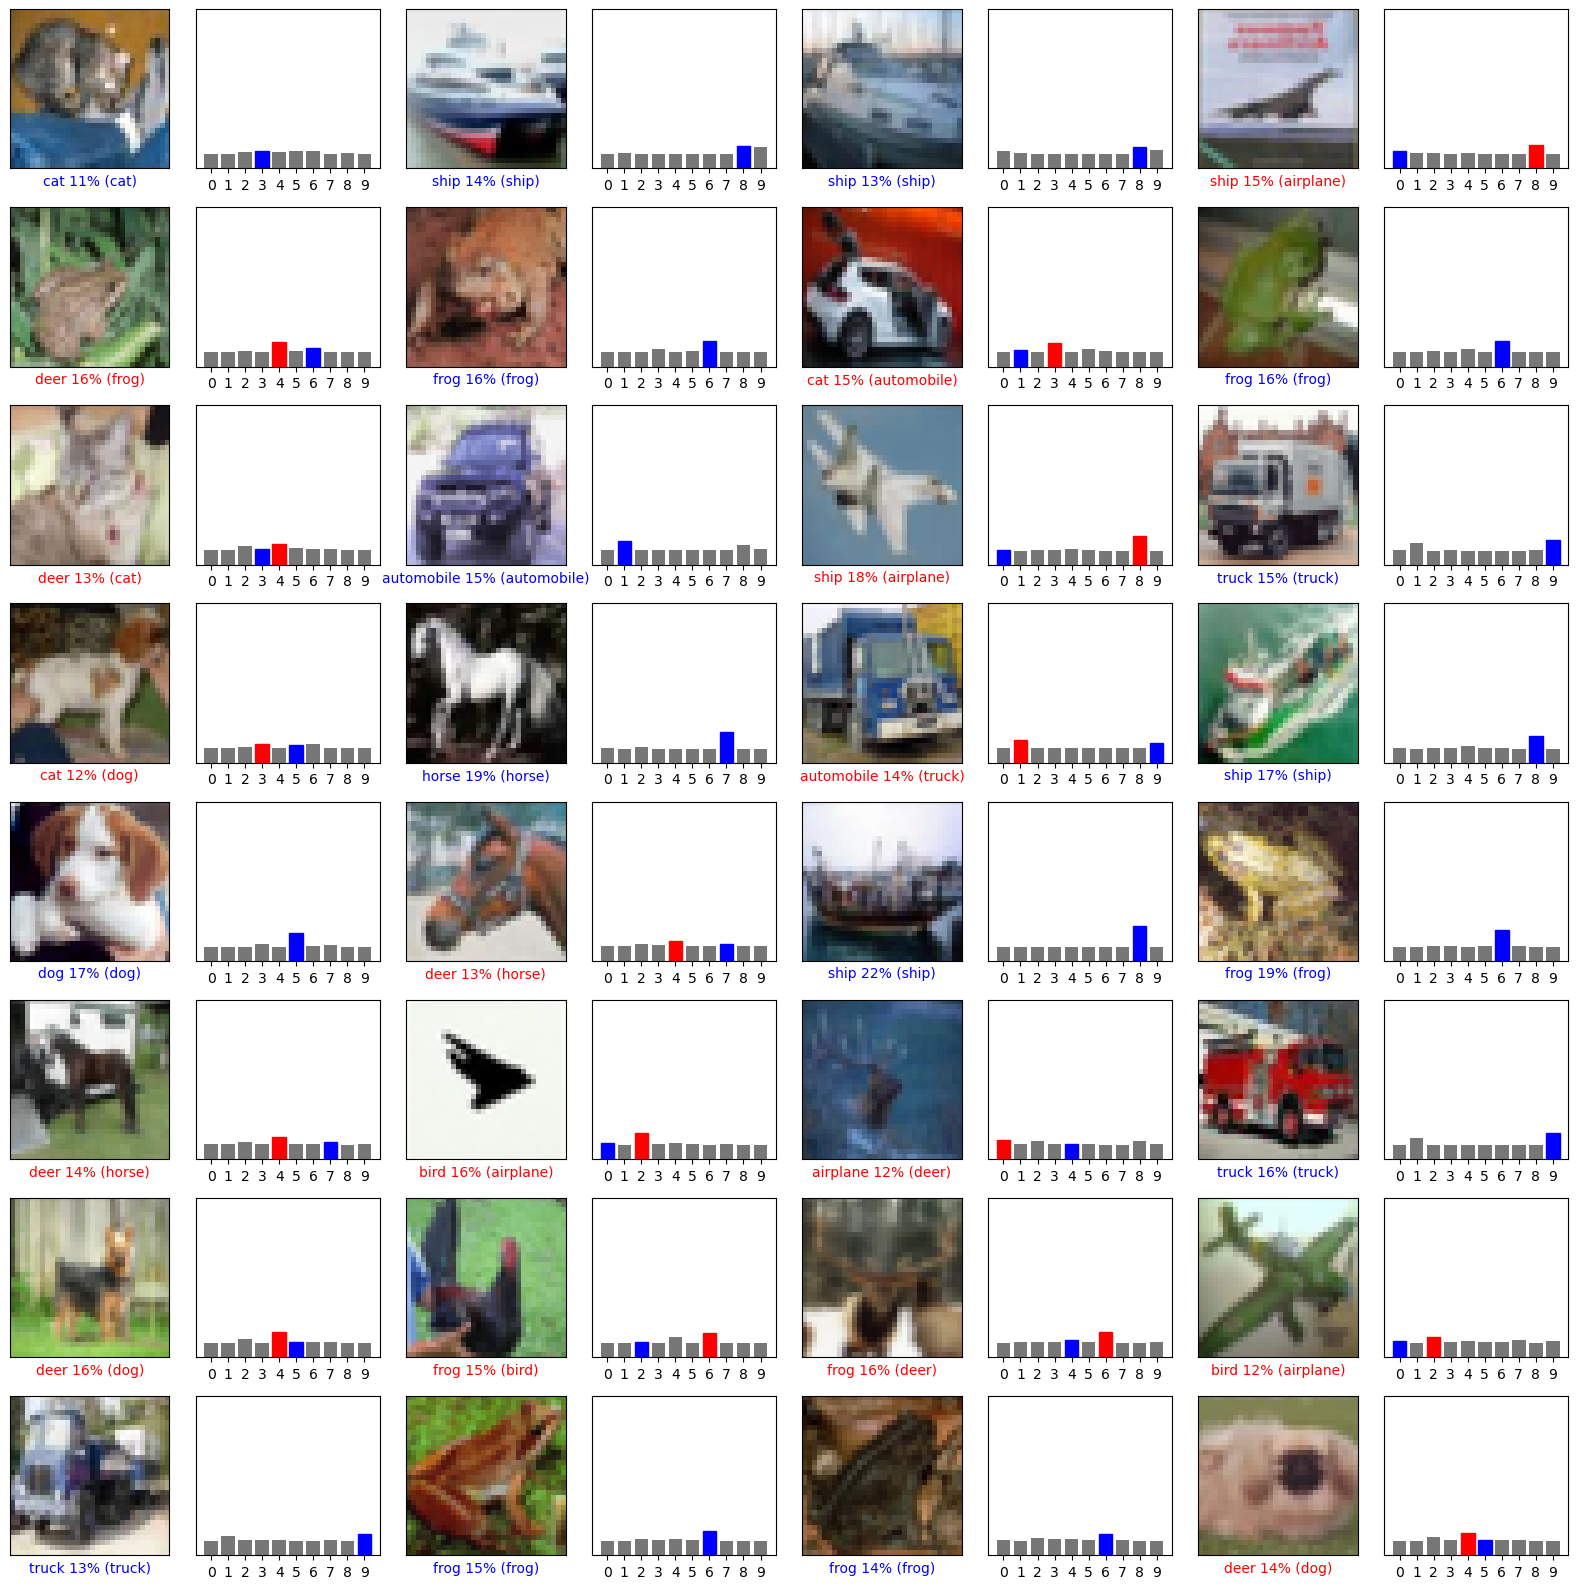

In [23]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions1[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions1[i], test_labels)
plt.tight_layout()
plt.show()

**Here we can see that while the model predicted relatively well...there are many classes, which have not been very accurate in the predictions and the precision is relatively low in many classes. Precision of identification is a metric, which will need to be improved upon significantly.**

 ---

## Model 2 - Adding convolutional layers

**The first step in building a convolutional neural network is to add convolutional layers. We have added three, with 32 neurons each to see how it compares to the simple model 1**

In [24]:
model2 = tf.keras.Sequential()

##The convolutional layers have been added before the model is compiled
model2.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
model2.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model2.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))


model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(10, activation='softmax'))
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model2_history = model2.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=30, 
    validation_data=(validation_images, validation_labels))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.3931 - loss: 1.6700 - val_accuracy: 0.5701 - val_loss: 1.2017
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6137 - loss: 1.1102 - val_accuracy: 0.6173 - val_loss: 1.0948
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6898 - loss: 0.8984 - val_accuracy: 0.6423 - val_loss: 1.0328
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.7464 - loss: 0.7361 - val_accuracy: 0.6436 - val_loss: 1.0471
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.8018 - loss: 0.5865 - val_accuracy: 0.6426 - val_loss: 1.0876
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8544 - loss: 0.4372 - val_accuracy: 0.6297 - val_loss: 1.2341
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.8922 - loss: 0.3218 - val_accuracy: 0.6232 - val_loss: 1.4734
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.9224 -

In [25]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   1059.9165740013123  seconds


In [26]:
test_loss, test_acc = model2.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - 8ms/step - accuracy: 0.5768 - loss: 5.0842

Test accuracy: 0.5767999887466431


**The model overfits relatively quickly when introducing convolutional neural networks, but seems to perform better with the test set**

In [27]:
probability_model2 = tf.keras.Sequential([model2, 
                                         tf.keras.layers.Softmax()])

In [28]:
predictions2 = probability_model2.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


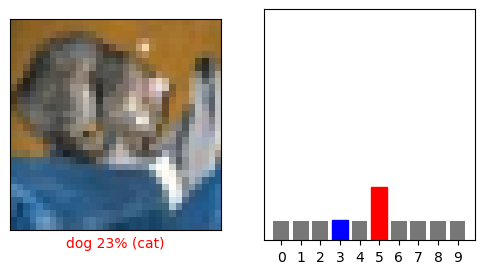

In [29]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions2[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions2[i],  test_labels)
plt.show()

**The convolutional layers have helped the model to predict more precisely, whether correct or not, seemingly identifying a ship instead of a cat. We will see if this pattern persists in the other labels**

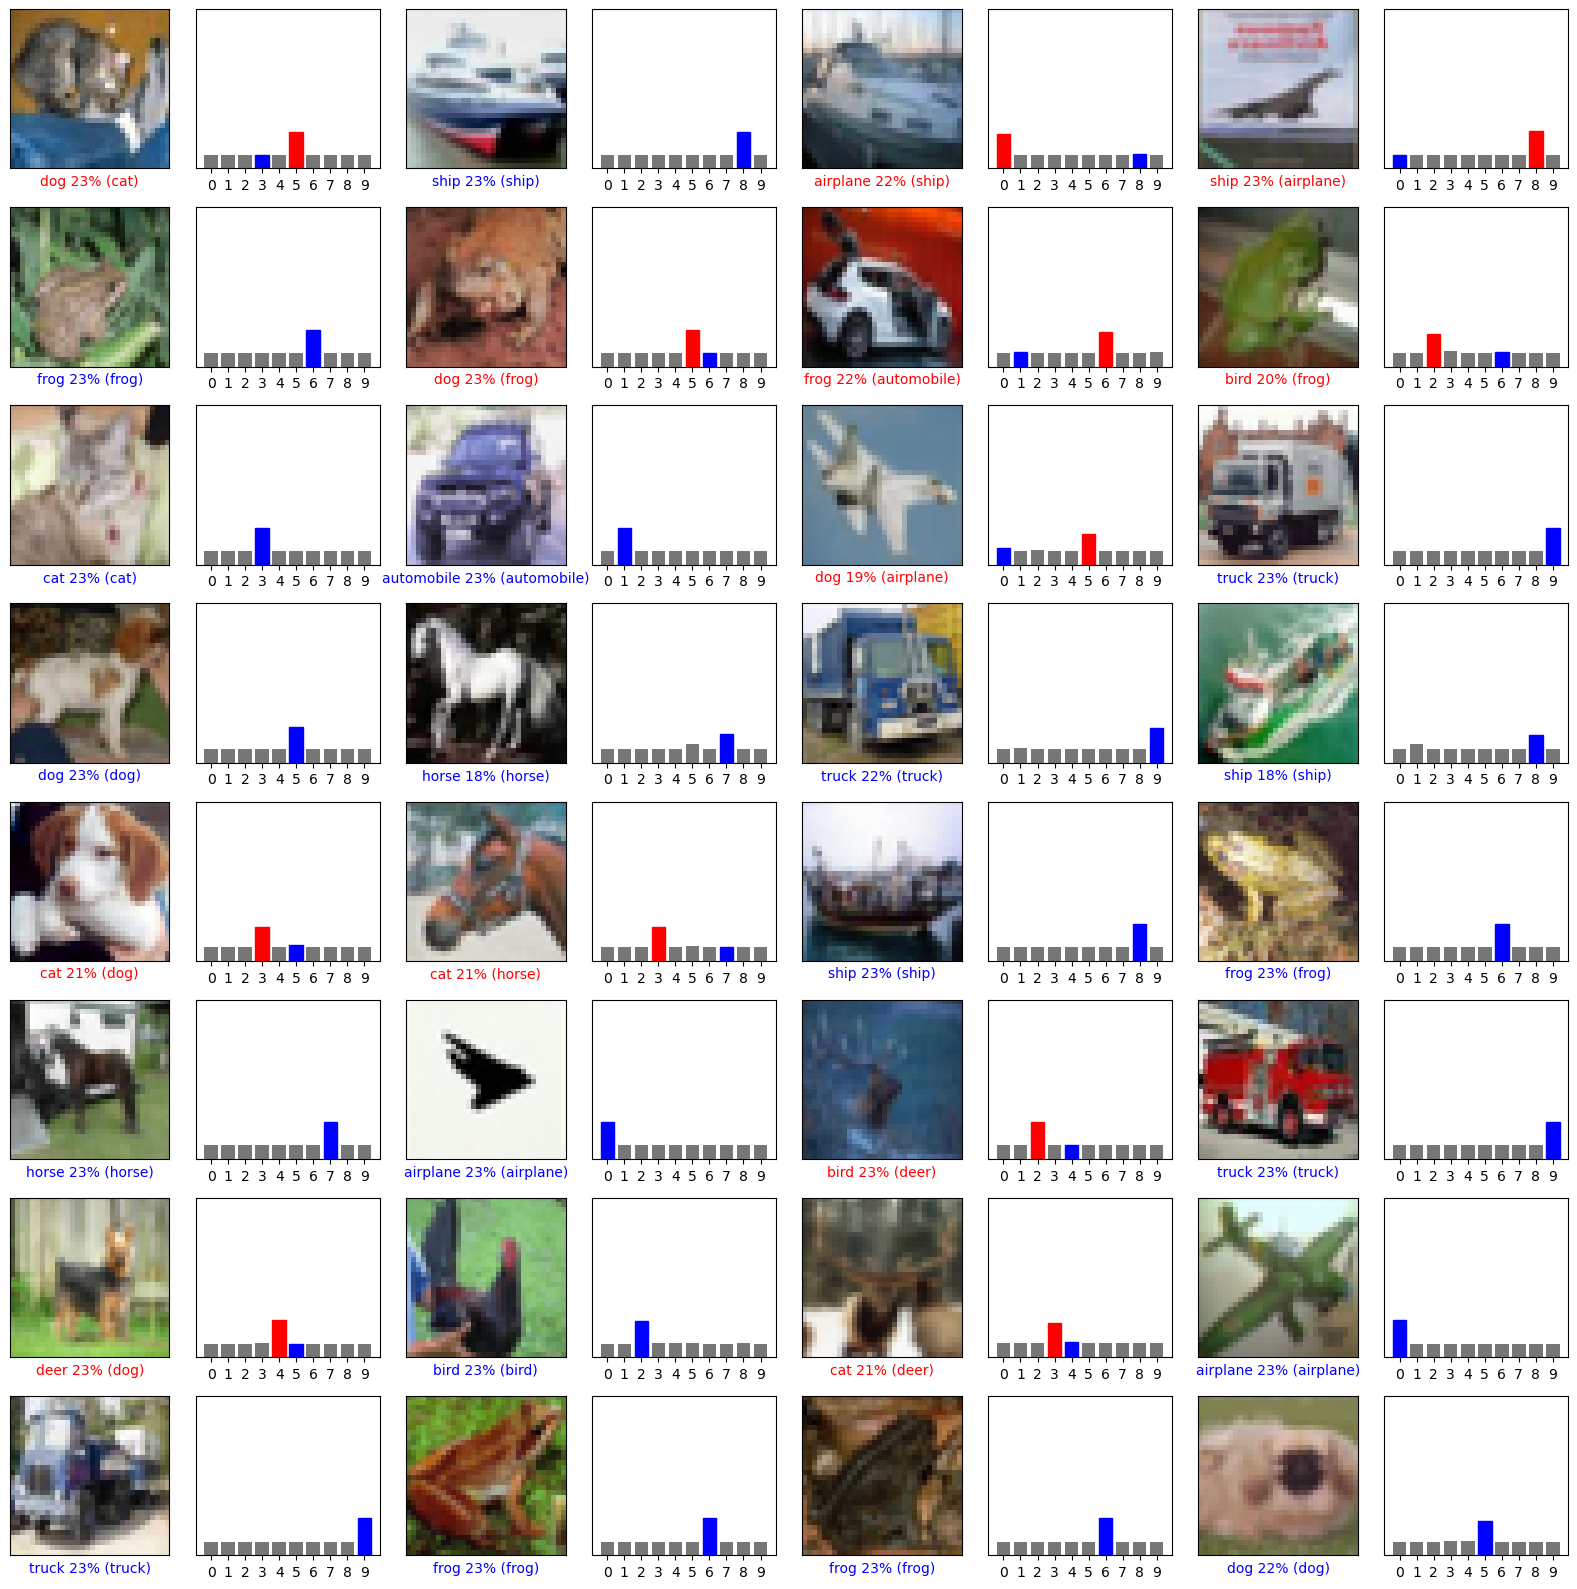

In [30]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions2[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions2[i], test_labels)
plt.tight_layout()
plt.show()

**As mentioned, the classes are identified with more certainty. Unfortunately they are not as accurate as we would like for them to be. We will compare the two models so far:**

---

## Comparing model 1 and 2

### Accuracy

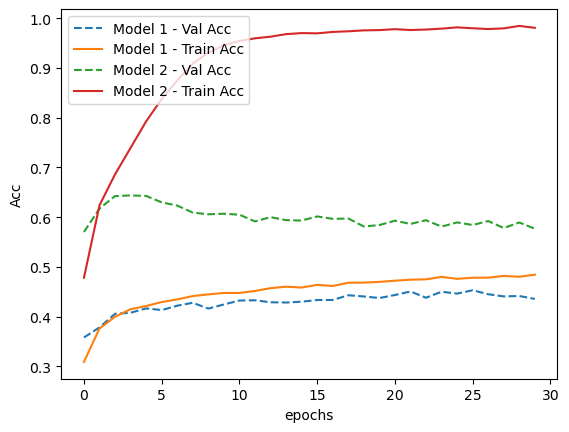

In [31]:
plt.plot(model1_history.history['val_accuracy'], '--', label="Model 1 - Val Acc")
plt.plot(model1_history.history['accuracy'], label="Model 1 - Train Acc")
plt.plot(model2_history.history['val_accuracy'], '--', label="Model 2 - Val Acc")
plt.plot(model2_history.history['accuracy'], label="Model 2 - Train Acc")

plt.ylabel('Acc')
plt.xlabel('epochs')
plt.legend()

### Loss

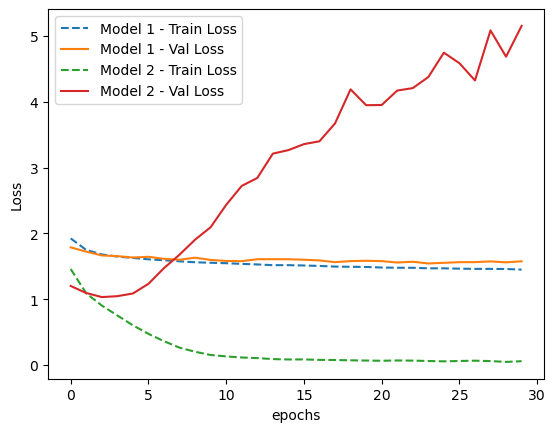

In [32]:
plt.plot(model1_history.history['loss'], '--', label="Model 1 - Train Loss")
plt.plot(model1_history.history['val_loss'], label="Model 1 - Val Loss")

plt.plot(model2_history.history['loss'], '--', label="Model 2 - Train Loss")
plt.plot(model2_history.history['val_loss'], label="Model 2 - Val Loss")


plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

**Model 1 seems to be more resilient with overfitting, however it is clear that the convolutions perform better, before overfitting around the third epoch. To remain consistent, I will focus on 30 epochs to better compare models**

****

## Model 3 - Playing with layers of convolutions, doubling the neurons each time

In [33]:
model3 = tf.keras.Sequential()

#Neurons are doubled each time it reaches a new layer
model3.add(tf.keras.layers.Conv2D(16, (3,3), input_shape=(32,32,3), activation='relu'))
model3.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model3.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model3.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))

model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(10, activation='softmax'))
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model3_history = model3.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=30, 
    validation_data=(validation_images, validation_labels))

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.4100 - loss: 1.6394 - val_accuracy: 0.5974 - val_loss: 1.1479
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 98s 78ms/step - accuracy: 0.6562 - loss: 1.0013 - val_accuracy: 0.6453 - val_loss: 1.0306
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.7309 - loss: 0.7772 - val_accuracy: 0.6696 - val_loss: 0.9590
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.8139 - loss: 0.5468 - val_accuracy: 0.6521 - val_loss: 1.0611
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 93s 74ms/step - accuracy: 0.8924 - loss: 0.3170 - val_accuracy: 0.6353 - val_loss: 1.2925
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 74ms/step - accuracy: 0.9454 - loss: 0.1646 - val_accuracy: 0.6370 - val_loss: 1.6889
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.9626 - loss: 0.1096 - val_accuracy: 0.6280 - val_loss: 1.7904
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 76ms/step - accuracy: 0.9749 -

In [34]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   3957.4138169288635  seconds


In [35]:
test_loss, test_acc = model3.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 7s - 21ms/step - accuracy: 0.6029 - loss: 4.8744

Test accuracy: 0.6029000282287598


**The model performs marginally better with the test set than model 2**

In [36]:
probability_model3 = tf.keras.Sequential([model3, 
                                         tf.keras.layers.Softmax()])

In [37]:
predictions3 = probability_model3.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


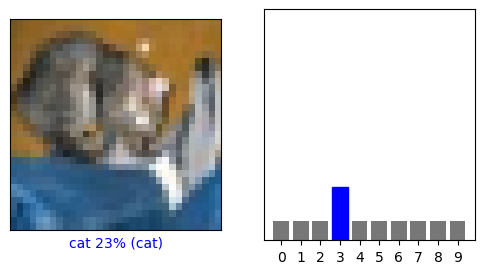

In [38]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions3[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions3[i],  test_labels)
plt.show()

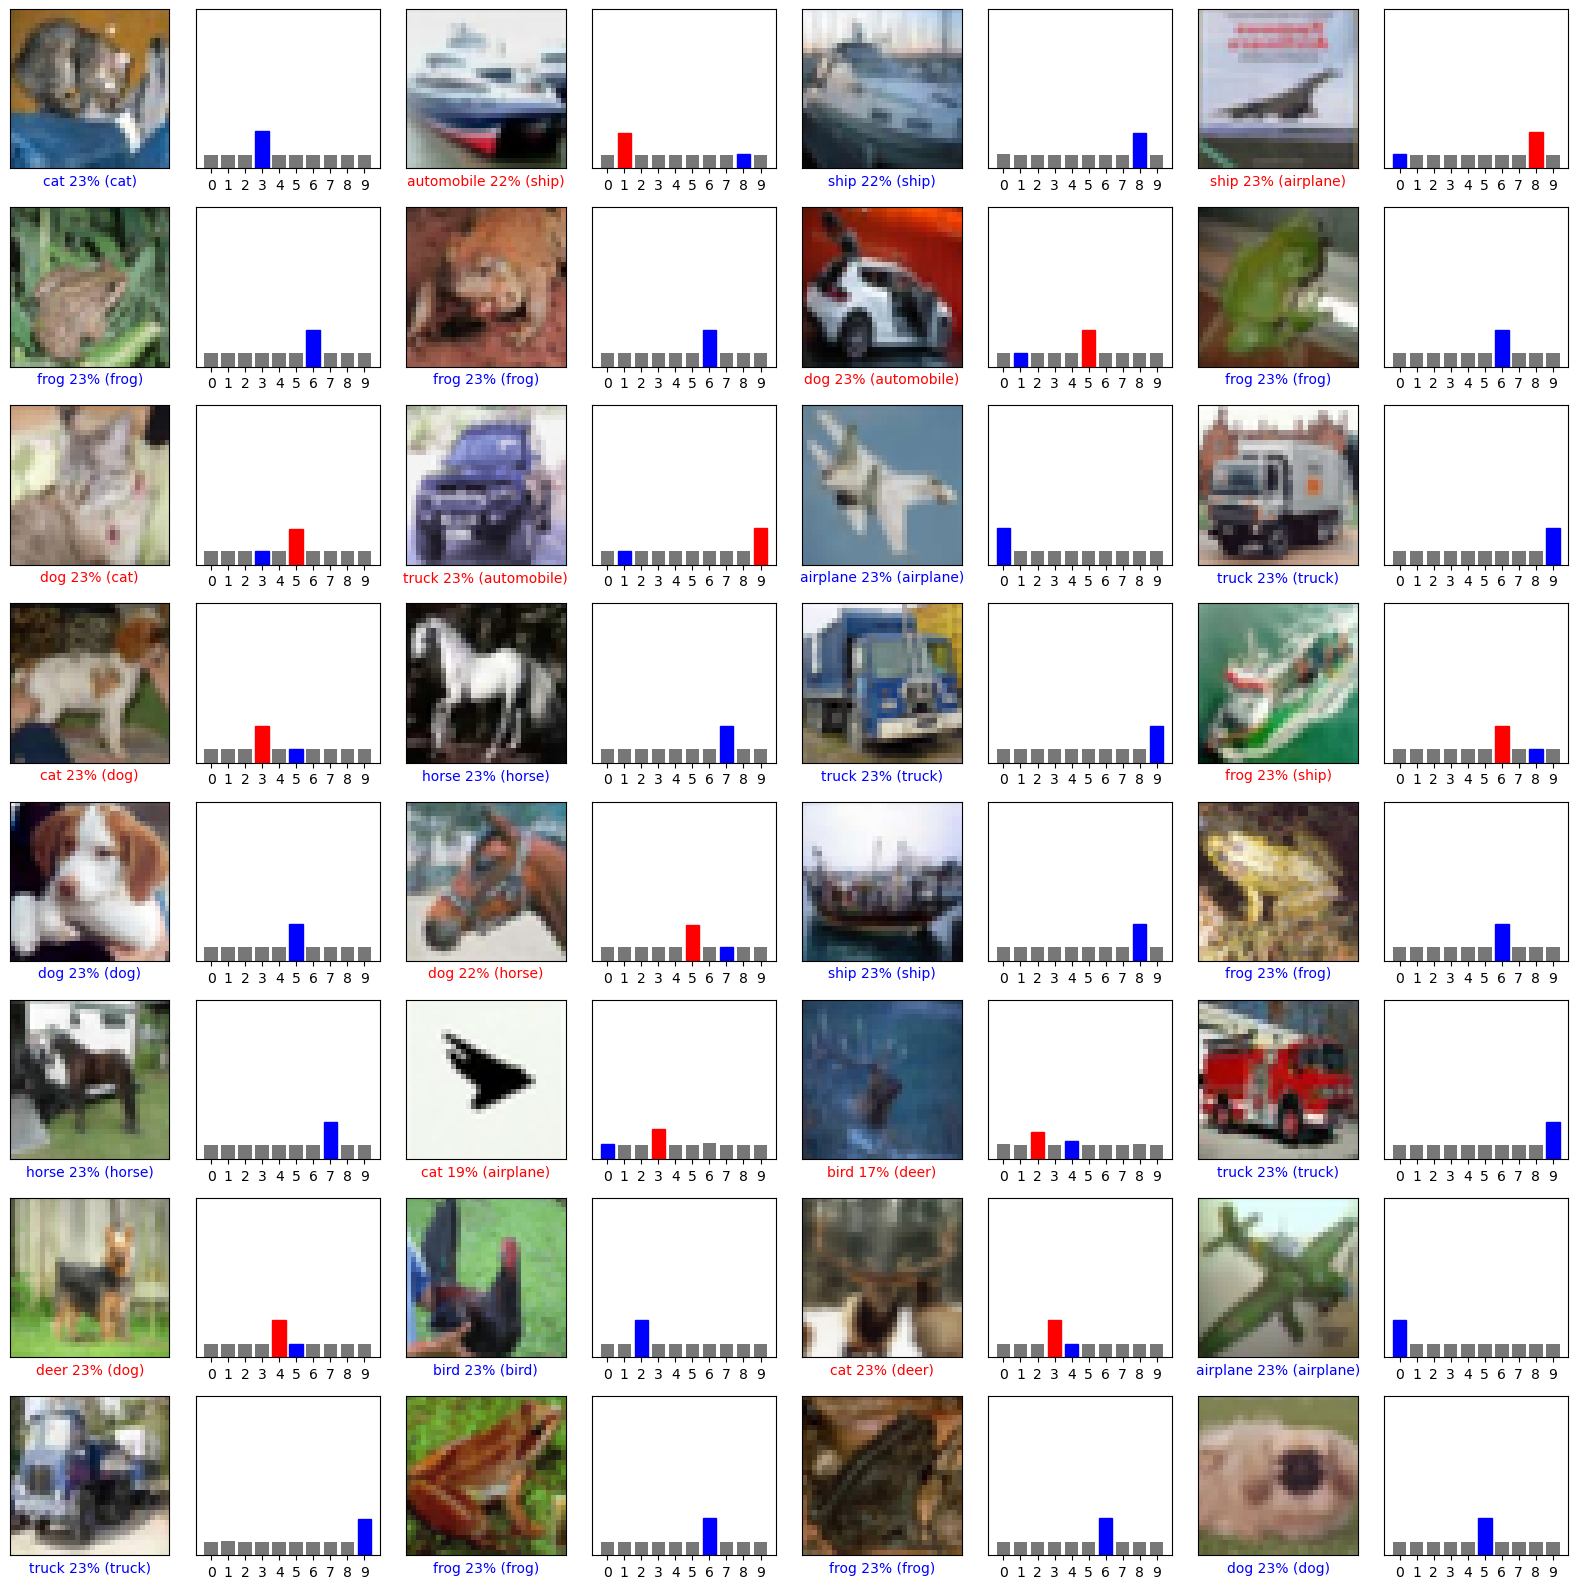

In [39]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions3[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions3[i], test_labels)
plt.tight_layout()
plt.show()

**The model seems to perform similarly to that of model 2. Although it is more accurate, it still cannot predict with high certainty we will see if there is any improvement when adding pooling to the model**

---

## Model 4 - Introducing Pooling to the three-layered model

In [40]:
model4 = tf.keras.Sequential()

#We have added some max pooling to the convolutional layers
model4.add(tf.keras.layers.Conv2D(16, (3,3), input_shape=(32,32,3), activation='relu'))
model4.add(tf.keras.layers.MaxPooling2D())
model4.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model4.add(tf.keras.layers.MaxPooling2D())
model4.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model4.add(tf.keras.layers.MaxPooling2D())

model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dense(10, activation='softmax'))
model4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model4_history = model4.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=30, 
    validation_data=(validation_images, validation_labels))

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3147 - loss: 1.8723 - val_accuracy: 0.5039 - val_loss: 1.3691
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5224 - loss: 1.3484 - val_accuracy: 0.5716 - val_loss: 1.2278
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5795 - loss: 1.2040 - val_accuracy: 0.6066 - val_loss: 1.1231
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6069 - loss: 1.1169 - val_accuracy: 0.6240 - val_loss: 1.0722
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6329 - loss: 1.0502 - val_accuracy: 0.6387 - val_loss: 1.0461
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6540 - loss: 0.9920 - val_accuracy: 0.6540 - val_loss: 1.0212
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6721 - loss: 0.9486 - val_accuracy: 0.6422 - val_loss: 1.0371
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6859 - loss: 0.9092 - 

In [41]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   4228.907299041748  seconds


In [42]:
test_loss, test_acc = model4.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - 3ms/step - accuracy: 0.6782 - loss: 1.0489

Test accuracy: 0.6782000064849854


**Pooling seems to have boosted the model's ability to predict accurately. We will see how this manifests with regards to the images**

In [43]:
probability_model4 = tf.keras.Sequential([model4, 
                                         tf.keras.layers.Softmax()])

In [44]:
predictions4 = probability_model4.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


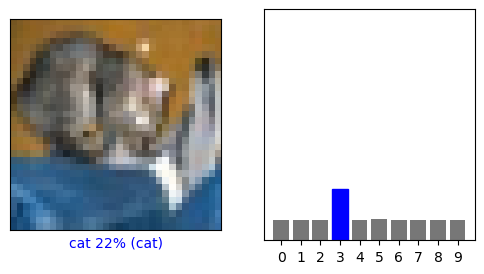

In [45]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions4[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions4[i],  test_labels)
plt.show()

**While the image has been accurately predicted, it is still not with as much certainty as that which would warrant deployment. We will, once again see if the same pattern occurs with multiple examples**

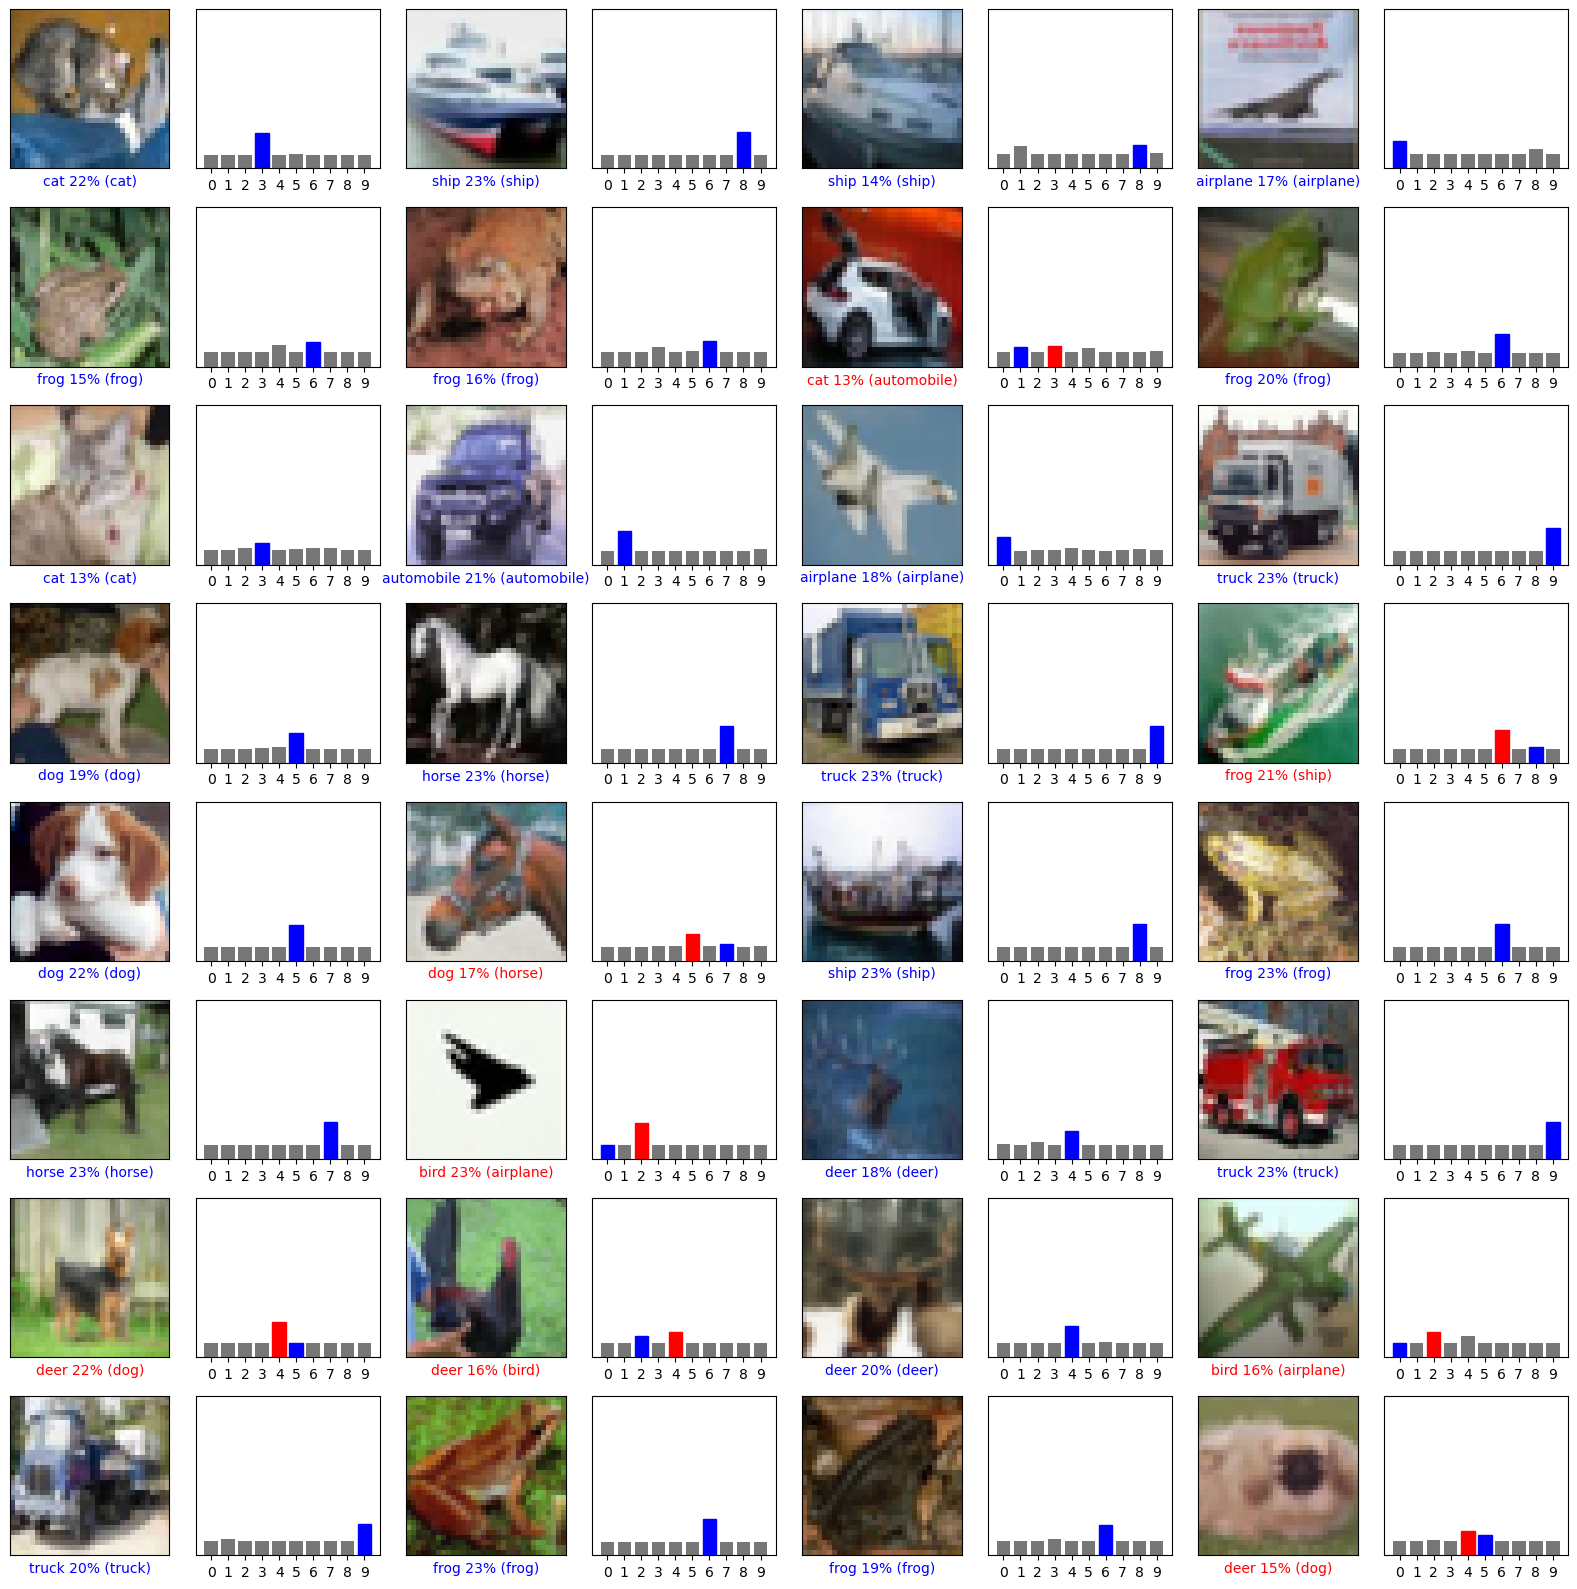

In [46]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions4[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions4[i], test_labels)
plt.tight_layout()
plt.show()

**The model predicts more accurately, however the level of precision is still not as high as would be desired.**

---

## Evaluation of models & Performance

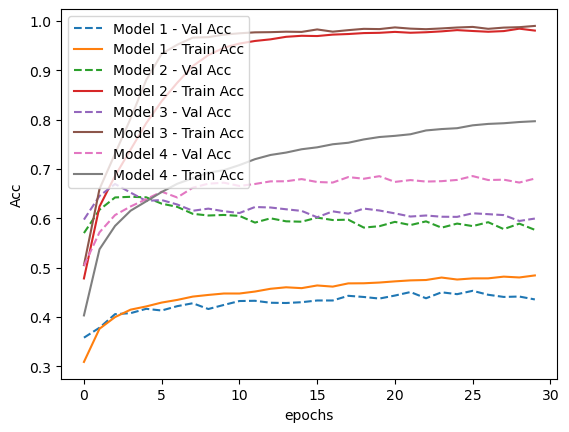

In [47]:
plt.plot(model1_history.history['val_accuracy'], '--', label="Model 1 - Val Acc")
plt.plot(model1_history.history['accuracy'], label="Model 1 - Train Acc")
plt.plot(model2_history.history['val_accuracy'], '--', label="Model 2 - Val Acc")
plt.plot(model2_history.history['accuracy'], label="Model 2 - Train Acc")
plt.plot(model3_history.history['val_accuracy'], '--', label="Model 3 - Val Acc")
plt.plot(model3_history.history['accuracy'], label="Model 3 - Train Acc")
plt.plot(model4_history.history['val_accuracy'], '--', label="Model 4 - Val Acc")
plt.plot(model4_history.history['accuracy'], label="Model 4 - Train Acc")

plt.ylabel('Acc')
plt.xlabel('epochs')
plt.legend();

**After reviewing the accuracy of the models, we can clearly see that:**

- Model 2 and 3 are the most probable with overfitting, although model 3 slightly outperforms model 2 with the validation set over a shorter amount of epochs.

- Model 4 is much more stable with pooling integrated, and overfitting seems limited when including pooling between convolutional layers.

- Model 1 performs extremely poorly, suggesting that a convolutional neural network is indeed the best option for unstructured data, such as images. 

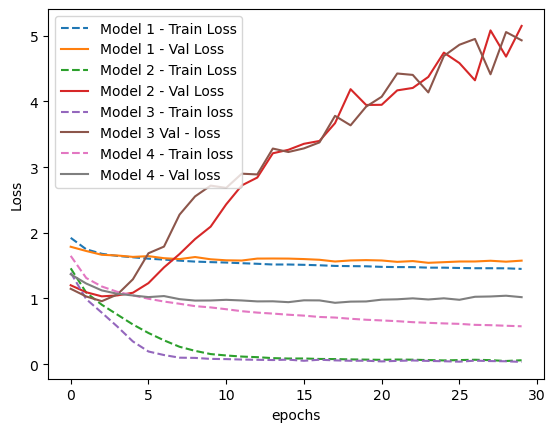

In [48]:
plt.plot(model1_history.history['loss'], '--', label="Model 1 - Train Loss")
plt.plot(model1_history.history['val_loss'], label="Model 1 - Val Loss")

plt.plot(model2_history.history['loss'], '--', label="Model 2 - Train Loss")
plt.plot(model2_history.history['val_loss'], label="Model 2 - Val Loss")

plt.plot(model3_history.history['loss'], '--', label="Model 3 - Train loss")
plt.plot(model3_history.history['val_loss'], label="Model 3 Val - loss")

plt.plot(model4_history.history['loss'], '--', label="Model 4 - Train loss")
plt.plot(model4_history.history['val_loss'], label="Model 4 - Val loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

**After reviewing the loss metrics of the models, we can see that:**

- Model 2 and 3 once again seem like the best options for a neural network, with the training data achieving extremely low loss, however the model quickly shows signs of overfitting. With the validation counterparts skyrocketing after only 4 epochs

- Model 4 is once again much more stable with pooling integrated, and overfitting seems limited when including pooling between convolutional layers. Over a higher number of epochs, the loss seems to be limited. 

- Model 1 Once again performs extremely poorly in comparison.

---

## Next Steps

**It looks like overfitting occurs quite quickly within neural networks with regards to both Accuracy and Loss. In phase 2 of the project I will work to build upon Model 4's architecture, and explore the following:**

- Significantly increasing the number of epochs to 250

- Data Augmentation